In [15]:
#This script produces visualizations of the exact likelihood, neural likelihood, and calibrated neural likelihood surfaces with 95% approximate confidence regions
#side by side
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as patch_polygon
from mpl_toolkits.axes_grid1 import ImageGrid

In [37]:
#Load exact likelihood surfaces and neural likelihood surfaces (both uncalibrated and calibrated)
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/gaussian_process"
exact_likelihood_surfaces_file = (local_folder + "/evaluate_nn/generate_data/data/" + image_name + "/single/reps/200/evaluation_ll_fields_10_by_10_density_" 
               + image_name + "_200.npy")
exact_likelihood_surfaces = np.load(exact_likelihood_surfaces_file)

version = "final_version"
uncalibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + image_name
                                        + "/" + version + "/uncalibrated/single/reps/200/"
                                        "/uncalibrated_neural_likelihood_surfaces_10_by_10_density_25_by_25_image_200.npy")
uncalibrated_neural_likelihood_surfaces = np.load(uncalibrated_neural_likelihood_surfaces_file)

calibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                              image_name + "/" + version + "/calibrated/single/reps/200/" +
                                              "calibrated_neural_likelihood_surfaces_10_by_10_density_25_by_25_image_200.npy")
calibrated_neural_likelihood_surfaces = np.load(calibrated_neural_likelihood_surfaces_file)

number_of_parameters = 100
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_10_by_10_density_" + image_name + "_200.npy"))
parameter_matrix = parameter_matrix[:,0,:]
possible_lengthscales = [round(.05*i,2) for i in range(1, 41)]
possible_variances = [round(.05*i,2) for i in range(1, 41)]
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [38]:
#Load exact and neural likelihood surfaces (both uncalibrated and calibrated) for multiple realizations
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/gaussian_process"
multi_exact_likelihood_surfaces_file = (local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                                  "/multi/5/reps/200/evaluation_ll_fields_10_by_10_density_" + image_name + "_multi_5_200.npy")
multi_exact_likelihood_surfaces = np.load(multi_exact_likelihood_surfaces_file)

version = "final_version"
multi_uncalibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" 
                                                      + image_name + "/" + version + "/uncalibrated/multi/5/reps/200" +
                                        "/uncalibrated_neural_likelihood_surfaces_10_by_10_density_25_by_25_multi_5_200.npy")
multi_uncalibrated_neural_likelihood_surfaces = np.load(multi_uncalibrated_neural_likelihood_surfaces_file)

multi_calibrated_neural_likelihood_surfaces_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                              image_name + "/" + version + "/calibrated/multi/5/reps/200/" +
                                              "calibrated_neural_likelihood_surfaces_10_by_10_density_25_by_25_multi_5_200.npy")
multi_calibrated_neural_likelihood_surfaces = np.load(multi_calibrated_neural_likelihood_surfaces_file)

number_of_parameters = 100
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_10_by_10_density_" + image_name + "_200.npy"))
parameter_matrix = parameter_matrix[:,0,:]
possible_lengthscales = [round(.05*i,2) for i in range(1, 41)]
possible_variances = [round(.05*i,2) for i in range(1, 41)]
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [32]:
#This function produces the 95 percent approximate confidence region over the parameter grid for a given neural likelihood surface
    #parameters:
        #neural_likelihood_surface: 40 by 40 matrix, neural likelihood surface for a given realization of the GP (uncalibrated or calibrated)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
def produce_neural_likelihood_confidence_region(neural_likelihood_surface, possible_lengthscales, possible_variances, C):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
    confidence_grid = np.where(field_difference <= C, 1, 0)

    variance_values = []
    lengthscale_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[min_val])

    confidence_region = np.zeros((len(variance_values),2))
    confidence_region[:,0] = lengthscale_values
    confidence_region[:,1] = variance_values

    return confidence_region

#This function produces the 95 percent approximate confidence region over the parameter grid for a given exact likelihood surface
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
def produce_exact_likelihood_confidence_region(exact_likelihood_surface, possible_lengthscales, possible_variances, C):

    max_field_value = np.max(exact_likelihood_surface)
    field_difference = 2*(max_field_value - exact_likelihood_surface)
    confidence_grid = np.where(field_difference <= C, 1, 0)

    variance_values = []
    lengthscale_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[min_val])

    confidence_region = np.zeros((len(variance_values),2))
    confidence_region[:,0] = lengthscale_values
    confidence_region[:,1] = variance_values

    return confidence_region

#Produce visualization of exact likelihood, uncalibrated neural likelihood, and calibrated neural likelihood surfaces
# with 95 percent approximate confidence region
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact likelihood surface for a given realization of the GP
        #uncalibrated_neural_likelihood_surface: 40 by 40 matrix, uncalibrated neural likelihood surface for a given realization of the GP)
        #calibrated_neural_likelihood_surface: 40 by 40 matrix, calibrated neural likelihood surface for a given realization of the GP)
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #true_lengthscale: the lengthscale which generated the realization of the gp
        #true_variance: the variance which generated the realization of the gp
        #irep: the number referring to the specific realization for the given parameter on the grid
        #constant: the color scale for the visualization is set to span the maximum value of the surface and the maximum value of the surface minuse constant
def produce_combined_confidence_region_surfaces(exact_likelihood_surface, 
                                             uncalibrated_neural_likelihood_surface, calibrated_neural_likelihood_surface, 
                                             possible_lengthscales, possible_variances, C, 
                                             true_lengthscale, true_variance, irep, constant, multi_or_single_case):
    
    fig = plt.figure(figsize=(20, 7.2))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,3),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )
    exact_likelihood_confidence_region = produce_exact_likelihood_confidence_region(exact_likelihood_surface, 
                                                                                                   possible_lengthscales, possible_variances, C)
    exact_likelihood_polygon = patch_polygon(exact_likelihood_confidence_region, facecolor = "none", 
                                                           edgecolor = "black", linewidth = 5)

    uncalibrated_neural_likelihood_confidence_region = produce_neural_likelihood_confidence_region(uncalibrated_neural_likelihood_surface, 
                                                                                                   possible_lengthscales, possible_variances, C)
    uncalibrated_neural_likelihood_polygon = patch_polygon(uncalibrated_neural_likelihood_confidence_region, facecolor = "none", 
                                                           edgecolor = "black", linewidth = 5)
    
    calibrated_neural_likelihood_confidence_region = produce_neural_likelihood_confidence_region(calibrated_neural_likelihood_surface, 
                                                                                                   possible_lengthscales, possible_variances, C)
    calibrated_neural_likelihood_polygon = patch_polygon(calibrated_neural_likelihood_confidence_region, facecolor = "none", 
                                                           edgecolor = "black", linewidth = 5)
    

    polygons = [exact_likelihood_polygon, uncalibrated_neural_likelihood_polygon, calibrated_neural_likelihood_polygon]
    surfaces = [exact_likelihood_surface, uncalibrated_neural_likelihood_surface, calibrated_neural_likelihood_surface]
    titles = ["Exact Likelihood", "Neural (Uncalibrated)", "Neural (Calibrated)"]

    x = np.linspace(.05, 2, 40)
    y = np.linspace(.05, 2, 40)
    X, Y = np.meshgrid(x, y)
    # Add data to image grid
    for i,ax in enumerate(grid):

        if(i == 0):
            Z = surfaces[i]
            Z = Z.reshape((40, 40))
            max_indices = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
            max_lengthscale = possible_lengthscales[max_indices[1]]
            max_variance = possible_variances[max_indices[0]]
            cp = ax.contourf(X, Y, Z, vmin = (np.amax(Z) -constant), vmax = np.amax(Z), levels = 120000)
            ax.set_ylabel("variance", fontsize = 30)
        else:
            Z = np.log(surfaces[i])
            print(np.min(Z))
            print(np.max(Z))
            Z = Z.reshape((40, 40))
            max_indices = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
            max_lengthscale = possible_lengthscales[max_indices[1]]
            max_variance = possible_variances[max_indices[0]]
            cp = ax.contourf(X, Y, Z, vmin = (np.amax(Z) -constant), vmax = np.amax(Z), levels = 12000)
        ax.add_patch(polygons[i])
        ax.scatter(true_lengthscale, true_variance, s = 200, marker = "*", c = "black")
        ax.scatter(max_lengthscale, max_variance, s = 200, marker = "o", c= "red")
        legend_elements = [Line2D([0], [0], marker='*', color='w', label='True',
                          markerfacecolor='black', markersize=40), 
                          Line2D([0], [0], marker='o', color='w', label='Estimate',
                          markerfacecolor='red', markersize=30), Line2D([0], [0], marker='_', color='black', label='95% CR',
                          markerfacecolor='none', markersize=40, linewidth = 8)]
        ax.legend(handles = legend_elements, facecolor='white', framealpha=1, fontsize="25")
        ax.set_title(titles[i])

    fig.text(0.5, 0.04, 'length scale', ha='center', va='center', fontsize = 30)
    #fig.text(0.1, 0.5, 'range', ha='center', va='center', rotation = 'vertical', fontsize = 40)
    plt.tight_layout()

    
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_approximate_confidence_regions/visualizations/combined/"
                + str(constant) + "_" + multi_or_single_case + "_combined_approximate_confidence_regions_95_variance_" 
                + str(round(true_variance, 2))
     + "_lengthscale_" + str(round(true_lengthscale, 2)) + "_rep_" + str(irep) + ".png")
    plt.savefig(fig_name)

In [ ]:
#Visualizations for single realizations case

#These are the indices for the 4 by 4 grid over the parameter space starting at (.4,.4) and increasing by increments of .4
indices = [11, 13, 15, 17, 31, 33, 35, 37, 51, 53, 55, 57, 71, 73, 75, 77]
constant = 10

for ipred in [33]:
    for irep in range(12,13):
        #first column is variance
        current_lengthscale = parameter_matrix[ipred,1]
        current_variance = parameter_matrix[ipred,0]
        produce_combined_confidence_region_surfaces(exact_likelihood_surfaces[ipred, irep,:,:], 
                                                    uncalibrated_neural_likelihood_surfaces[ipred, irep,:,:],
                                                    calibrated_neural_likelihood_surfaces[ipred, irep,:,:], 
                                                    possible_lengthscales, possible_variances, C,
                                                    current_lengthscale, current_variance, irep, constant, "single")

Locator attempting to generate 108654 ticks ([-47220.4, ..., -3759.199999999997]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10752 ticks ([-169.66, ..., 45.360000000000014]), which exceeds Locator.MAXTICKS (1000).


-169.6483043903969
45.35344535329272


Locator attempting to generate 11951 ticks ([-52.182, ..., 19.518]), which exceeds Locator.MAXTICKS (1000).


-52.178045488974064
19.515550773556047


/tmp/ipykernel_49611/3237444805.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


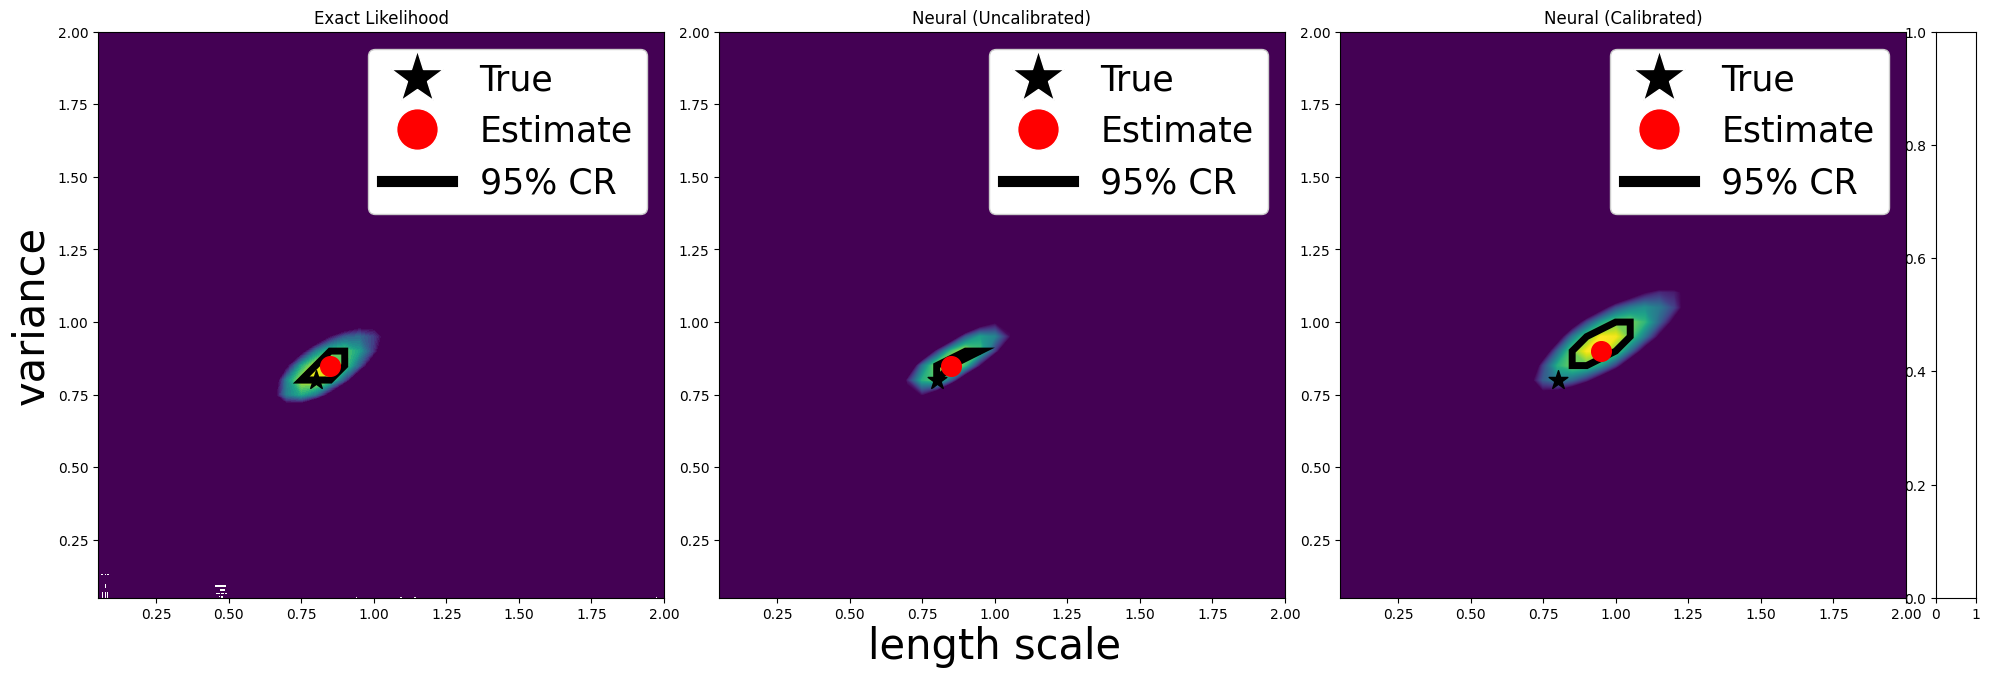

In [39]:
#Visualizations for multiple realizations case

#These are the indices for the 4 by 4 grid over the parameter space starting at (.4,.4) and increasing by increments of .4
indices = [11, 13, 15, 17, 31, 33, 35, 37, 51, 53, 55, 57, 71, 73, 75, 77]
constant = 10

for ipred in [33]:
    for irep in range(12,13):
        #first column is variance
        current_lengthscale = parameter_matrix[ipred,1]
        current_variance = parameter_matrix[ipred,0]
        produce_combined_confidence_region_surfaces(multi_exact_likelihood_surfaces[ipred, irep,:,:], 
                                                    multi_uncalibrated_neural_likelihood_surfaces[ipred, irep,:,:],
                                                    multi_calibrated_neural_likelihood_surfaces[ipred, irep,:,:], 
                                                    possible_lengthscales, possible_variances, C,
                                                    current_lengthscale, current_variance, irep, constant, "multi")

In [40]:
np.argmax(multi_uncalibrated_neural_likelihood_surfaces[33,12,:,:])

656

In [41]:
np.argmax(multi_calibrated_neural_likelihood_surfaces[33,12,:,:])

698